In [1]:
# Imports for Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
import qiskit.circuit.library as qulib
from qiskit_aer import AerSimulator

# Various imports
import numpy as np

##IBMQ.save_account('Put your token')
##provider = IBMQ.load_account()
##IBMQ.get_provider(hub='ibm-q', group='open', project = 'main')

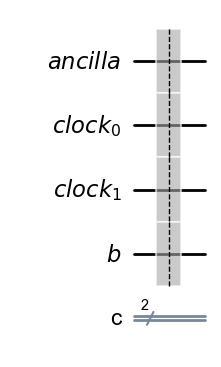

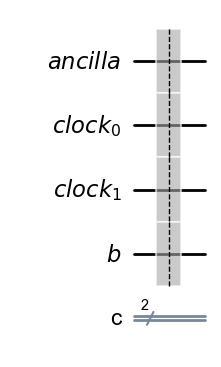

In [2]:
# Create the various registers needed
clock = QuantumRegister(2, name='clock')
input_reg = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, input_reg, measurement)

circuit.barrier()
circuit.draw(output='mpl')

In [3]:
def qft_dagger(circ, q, n):      
    circ.h(clock[1]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cp(-np.pi/float(2**(k-j)), q[k], q[j]);
        #circ.cu(0,0,0,-np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[0]);
    circ.swap(clock[0], clock[1]);

def qft(circ, q, n):
    circ.swap(clock[0], clock[1]);
    circ.h(clock[0]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cp(np.pi/float(2**(k-j)), q[k], q[j]);
        #circ.cu(0,0,0,np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[1]);

In [4]:
def qpe(circ, clock, target):
    circuit.barrier()
    #U=e^{i*A*t} <--
    circuit.cu(np.pi / 2, -np.pi / 2, np.pi / 2, 3 * np.pi / 4, clock[0], input_reg, label='U');
    
    # U^2=e^{i*A*t*2} <--
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input_reg, label='U2');

    circuit.barrier();
    
    # Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(circuit, clock, 2)
    
def inv_qpe(circ, clock, target):
    
    # Perform a QFT on the register holding the eigenvalues
    qft(circuit, clock, 2)

    circuit.barrier()

    # U^-2=e^{i*A*t*2} <--
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input_reg, label='U2');

    #circuit.barrier();

    # U^-1=e^{i*A*t} <--
    circuit.cu(np.pi / 2, np.pi / 2, -np.pi / 2, -3 * np.pi / 4, clock[0], input_reg, label='U');

    circuit.barrier()

In [5]:
def hhl(circ, ancilla, clock, input, measurement):
    
    qpe(circ, clock, input)

    circuit.barrier()
    
    # This section is to test and implement  <--
    #circuit.cry(np.pi, clock[0], ancilla)
    #circuit.cry(np.pi/3, clock[1], ancilla)
    ccRy1=qulib.RYGate(np.pi).control(2, ctrl_state='01')
    circuit.append(ccRy1,[clock[0],clock[1],ancilla])
    ccRy2=qulib.RYGate(np.pi/3).control(2, ctrl_state='10')
    circuit.append(ccRy2,[clock[0],clock[1],ancilla])
    circuit.barrier()
    
    circuit.measure(ancilla, measurement[0])
    circuit.barrier()
    inv_qpe(circ, clock, input)

In [6]:
# State preparation. 
intial_state = [0,1]
circuit.initialize(intial_state, 3)

circuit.barrier()

# Perform a Hadamard Transform
circuit.h(clock)

hhl(circuit, ancilla, clock, input_reg, measurement)

# Perform a Hadamard Transform
circuit.h(clock)

circuit.barrier()


#circuit.measure(input, measurement[1])

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "ancilla"), index=0>, <Qubit register=(2, "clock"), index=0>, <Qubit register=(2, "clock"), index=1>, <Qubit register=(1, "b"), index=0>), clbits=())

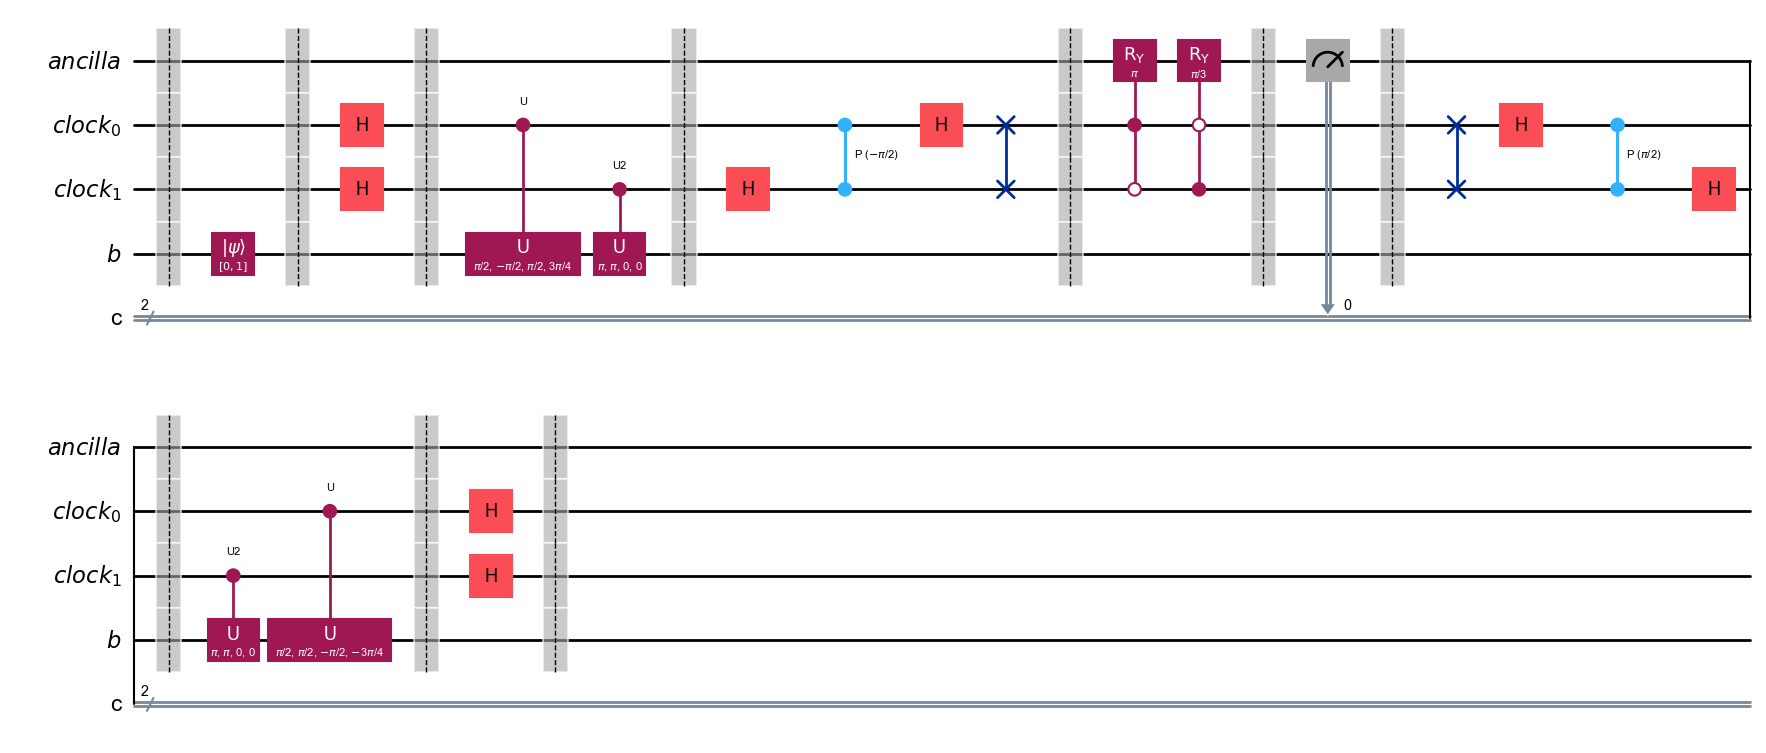

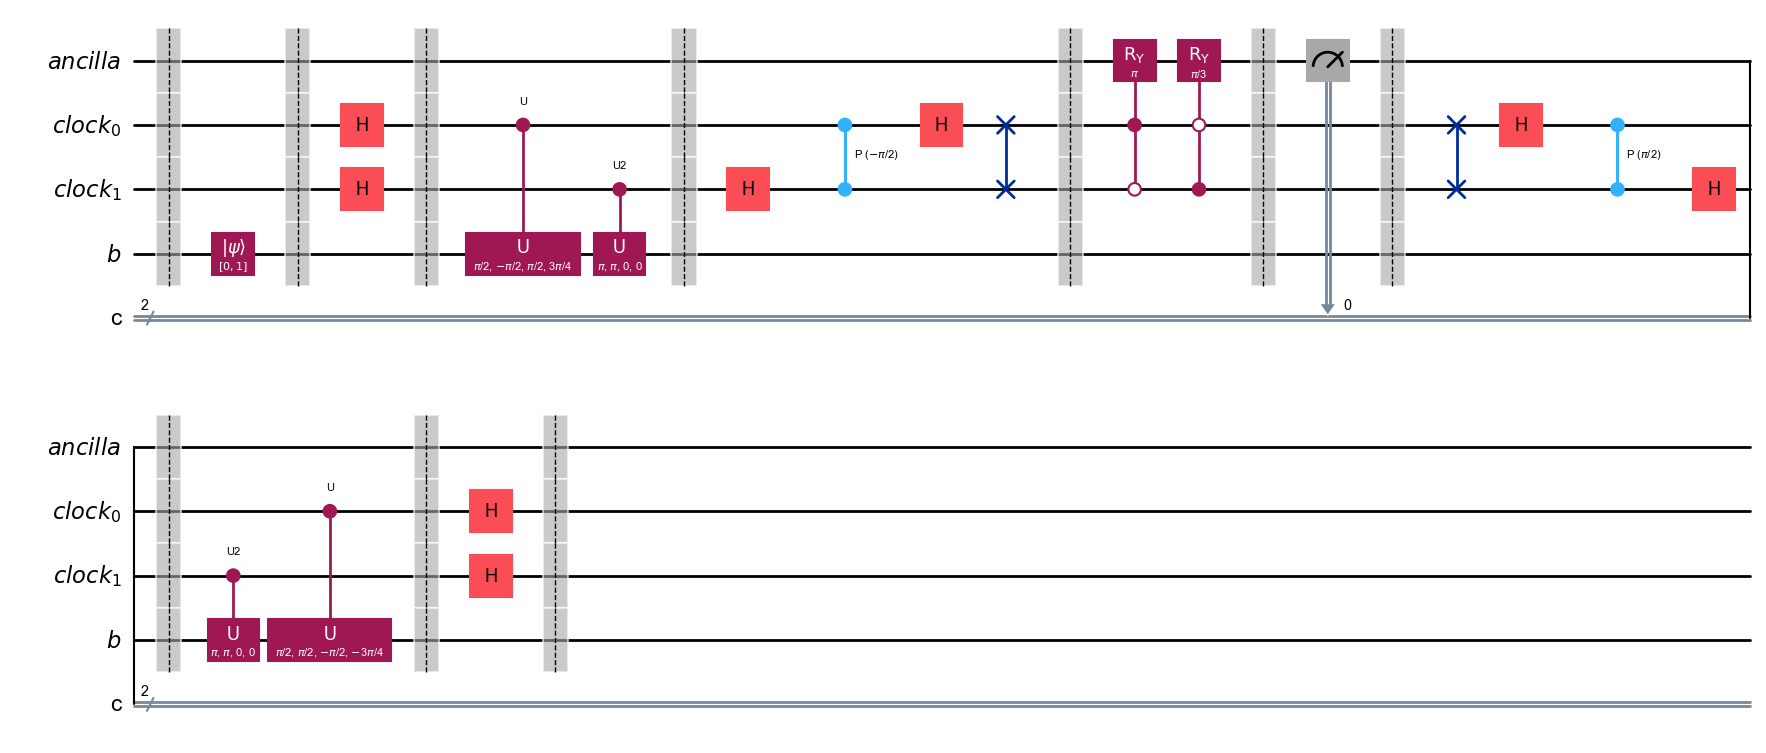

In [7]:
circuit.draw('mpl',scale=1)

In [8]:
simulator = AerSimulator()

transpiled_circuit = transpile(circuit, simulator)

shots = 10000
job = simulator.run(transpiled_circuit, shots=shots)
result = job.result()

counts = result.get_counts()
print(counts)

{'01': 6278, '00': 3722}


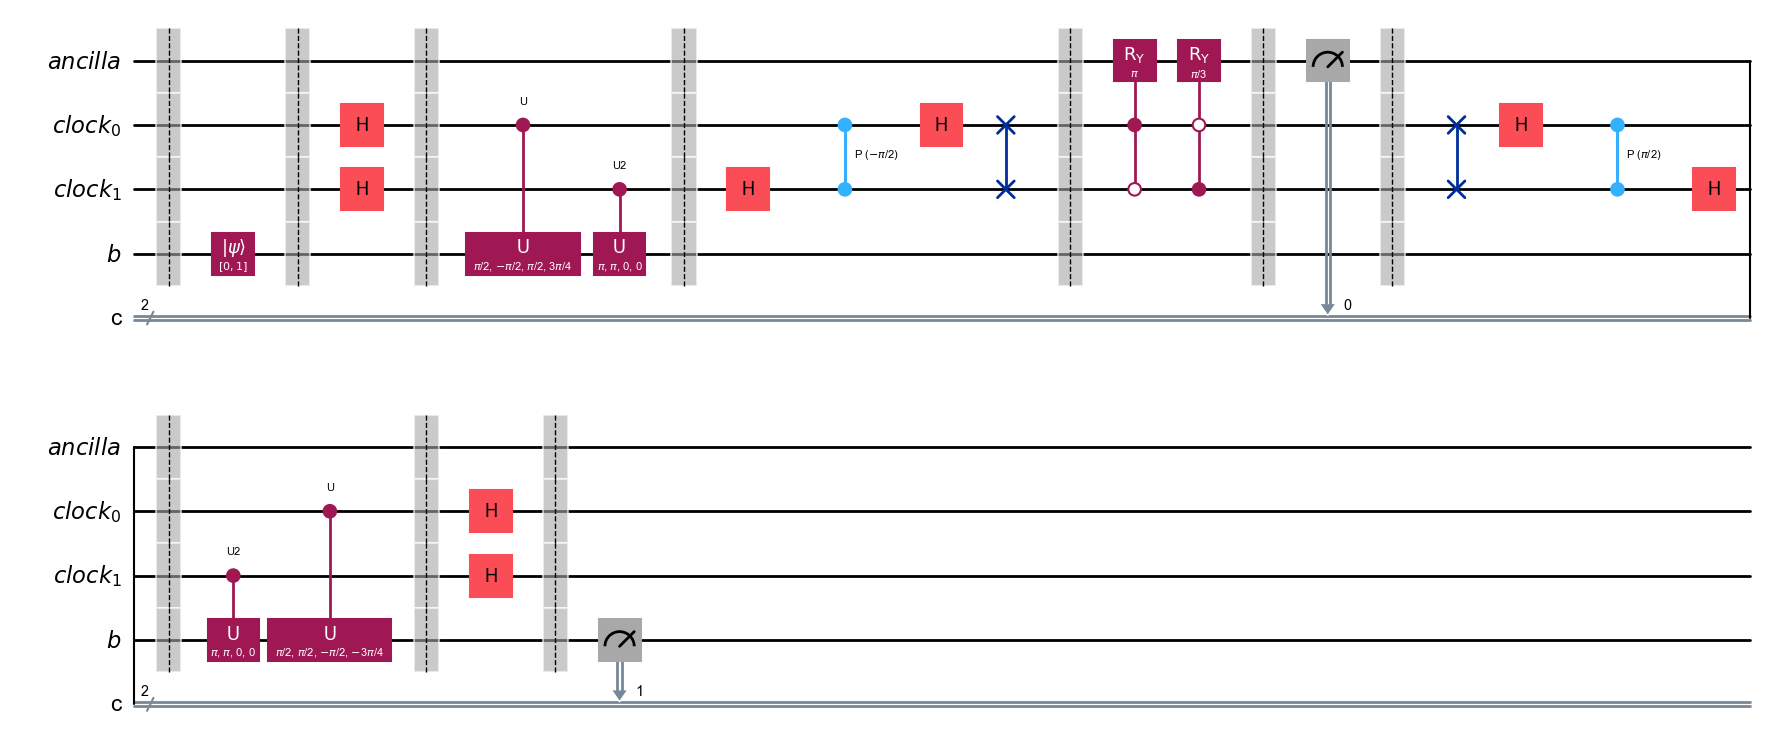

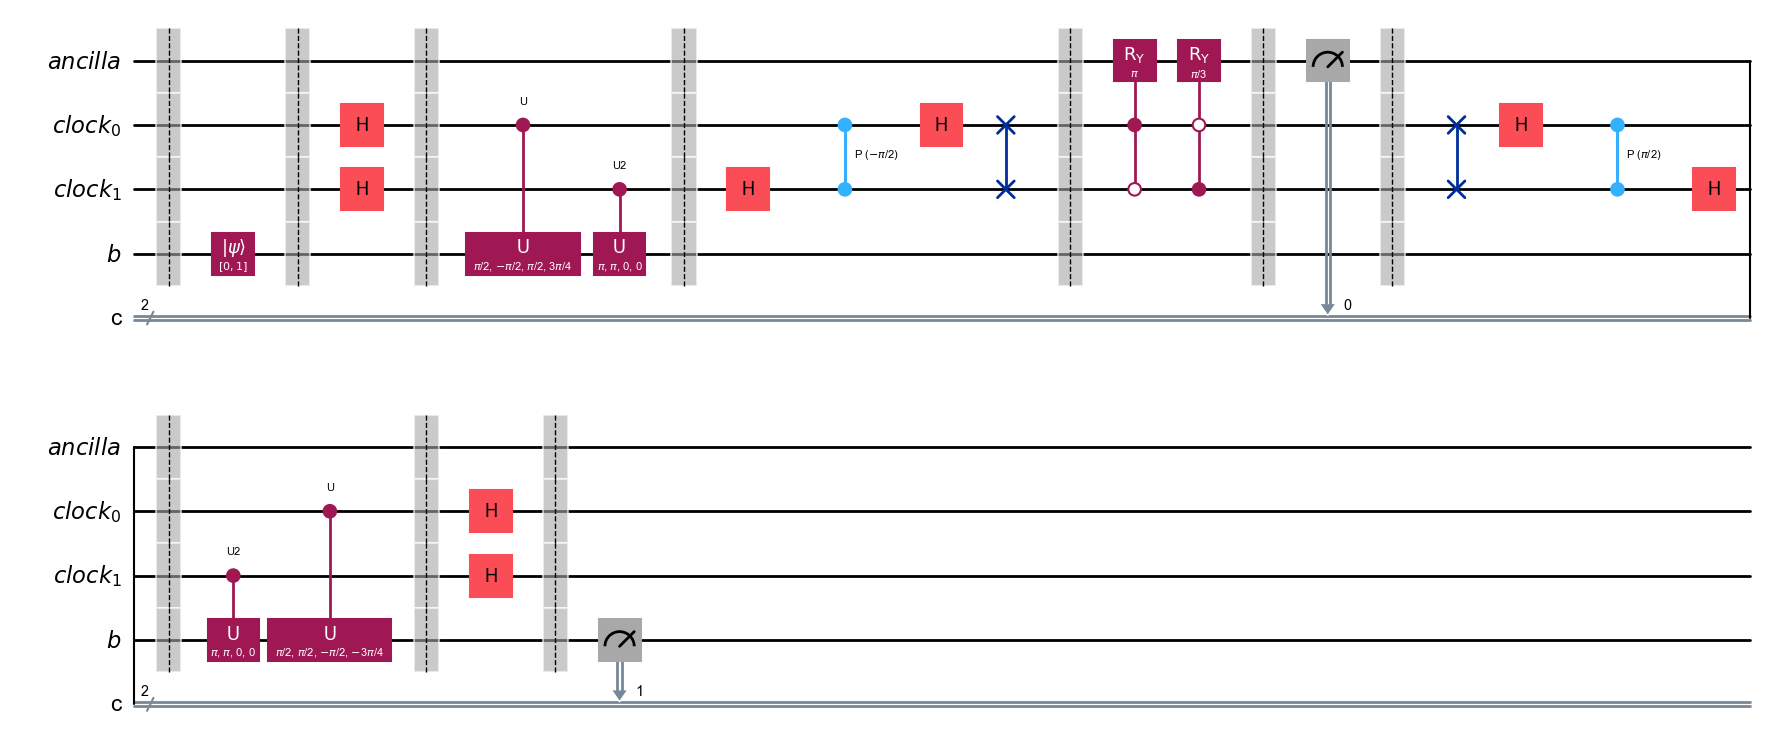

In [9]:
circuit.measure(input_reg, measurement[1])
circuit.draw('mpl',scale=1)

In [10]:
print(counts)

{'01': 6278, '00': 3722}


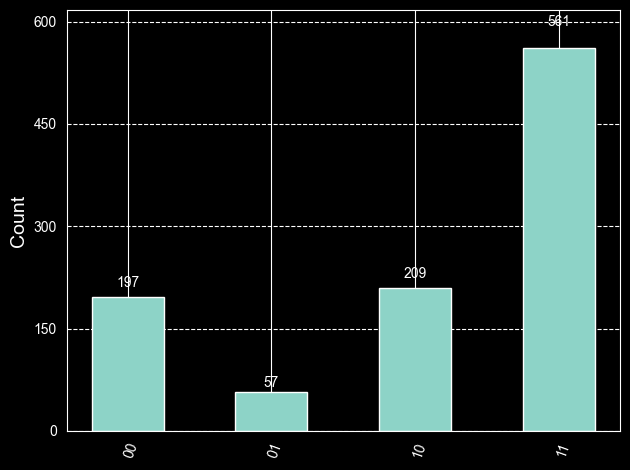

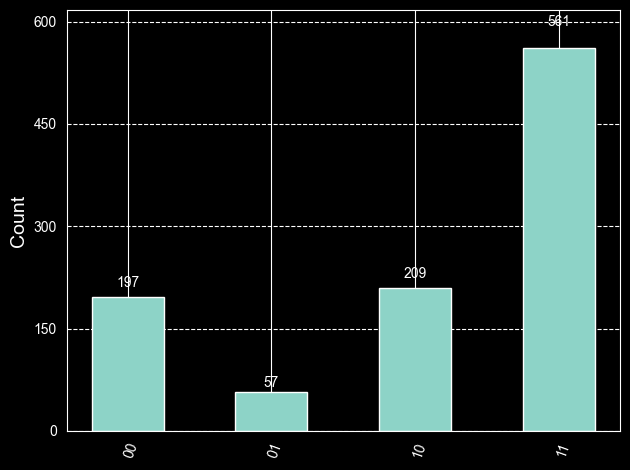

In [11]:
probe=1024
#65536
# Execute the circuit using the simulator
simulator = AerSimulator()

transpiled_circuit = transpile(circuit, simulator)
job = simulator.run(transpiled_circuit, shots=probe)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
counts = result.get_counts()

# Display the results
plot_histogram(counts)

In [12]:
print(counts)

{'01': 57, '00': 197, '10': 209, '11': 561}


In [13]:
67/593

0.11298482293423272

In [14]:
1/9

0.1111111111111111

In [15]:
2*np.arcsin(1/3)

np.float64(0.6796738189082439)

In [16]:
np.rad2deg(0.6796738189082439)

np.float64(38.94244126898138)

In [17]:
38.94244126898138/180

0.21634689593878548

Task 1 & 2: Classical Solution and Comparison

In [18]:
# --- Task 2: Classical Solution ---
import numpy as np

# Define Matrix A and Vector b based on the PDF Task
A = np.array([[2, -1],
              [-1, 2]])
b = np.array([0, 1])

# Calculate x = A^-1 * b
A_inv = np.linalg.inv(A)
x = np.dot(A_inv, b)

# Normalize the result to compare with Quantum Amplitudes
norm_x = np.linalg.norm(x)
x_normalized = x / norm_x

print(f"Matrix A:\n{A}")
print(f"Vector b: {b}")
print(f"Classical Solution x: {x}")
print(f"Normalized Classical State |x>: {x_normalized}")

# Calculate ratio x0/x1 for comparison
print(f"Ratio x0/x1: {x[0]/x[1]}")
print(f"Probability ratio P(0)/P(1) (x0^2/x1^2): {(x_normalized[0]**2)/(x_normalized[1]**2)}")

Matrix A:
[[ 2 -1]
 [-1  2]]
Vector b: [0 1]
Classical Solution x: [0.33333333 0.66666667]
Normalized Classical State |x>: [0.4472136  0.89442719]
Ratio x0/x1: 0.5
Probability ratio P(0)/P(1) (x0^2/x1^2): 0.25


Task 1: HHL Implementation (Updated Gates)

In [19]:
# --- Task 1: HHL Implementation with PDF Parameters ---

def qpe(circ, clock, target):
    circ.barrier()

    # U = e^{i*A*t}
    # Parameters from PDF Tip 1 for U: theta=pi, phi=0, lambda=-pi/2, gamma=0
    circ.cu(np.pi, 0, -np.pi / 2, 0, clock[0], target, label='U')

    # U^2 = e^{i*A*t*2}
    # Parameters from PDF Tip 1 for U^2: theta=0, phi=0, lambda=0, gamma=pi
    circ.cu(0, 0, 0, np.pi, clock[1], target, label='U2')

    circ.barrier()

    # Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(circ, clock, 2)

def inv_qpe(circ, clock, target):

    # Perform a QFT on the register holding the eigenvalues
    qft(circ, clock, 2)

    circ.barrier()

    # U^-2
    # Parameters from PDF Tip 2 for U^-2: theta=0, phi=0, lambda=0, gamma=pi
    circ.cu(0, 0, 0, np.pi, clock[1], target, label='U-2')

    # U^-1
    # Parameters from PDF Tip 2 for U^-1: theta=pi, phi=pi/2, lambda=-pi/2, gamma=pi
    circ.cu(np.pi, np.pi / 2, -np.pi / 2, np.pi, clock[0], target, label='U-1')

    circ.barrier()

def hhl(circ, ancilla, clock, input_reg, measurement):

    qpe(circ, clock, input_reg)

    circ.barrier()

    # --- Eigenvalue Inversion (Rotation) ---
    # Based on PDF Tip 3
    # Eigenvalue 1 maps to |01>: Rotate by pi
    # Eigenvalue 3 maps to |11>: Rotate by 11*pi/50 (approx 0.691)

    # Rotation for state |01> (Lambda = 1)
    ccRy1 = qulib.RYGate(np.pi).control(2, ctrl_state='01')
    circ.append(ccRy1, [clock[0], clock[1], ancilla])

    # Rotation for state |11> (Lambda = 3)
    # Using explicit value from Tip 3
    theta_3 = (11/50) * np.pi
    ccRy2 = qulib.RYGate(theta_3).control(2, ctrl_state='11')
    circ.append(ccRy2, [clock[0], clock[1], ancilla])

    circ.barrier()

    # Measure Ancilla
    circ.measure(ancilla, measurement[0])

    circ.barrier()

    inv_qpe(circ, clock, input_reg)

Execution and Circuit Construction

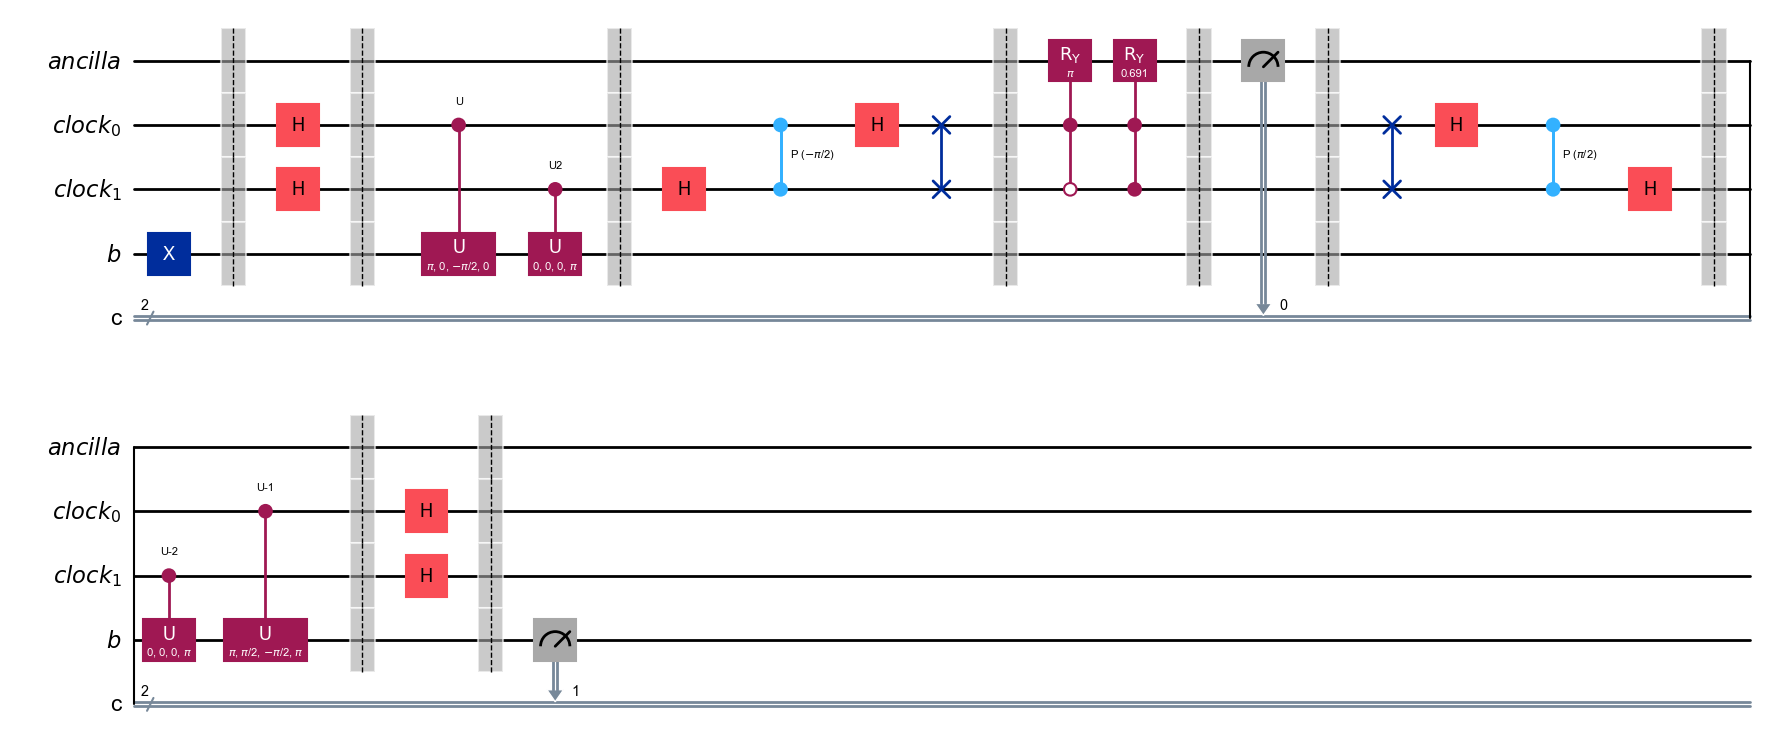

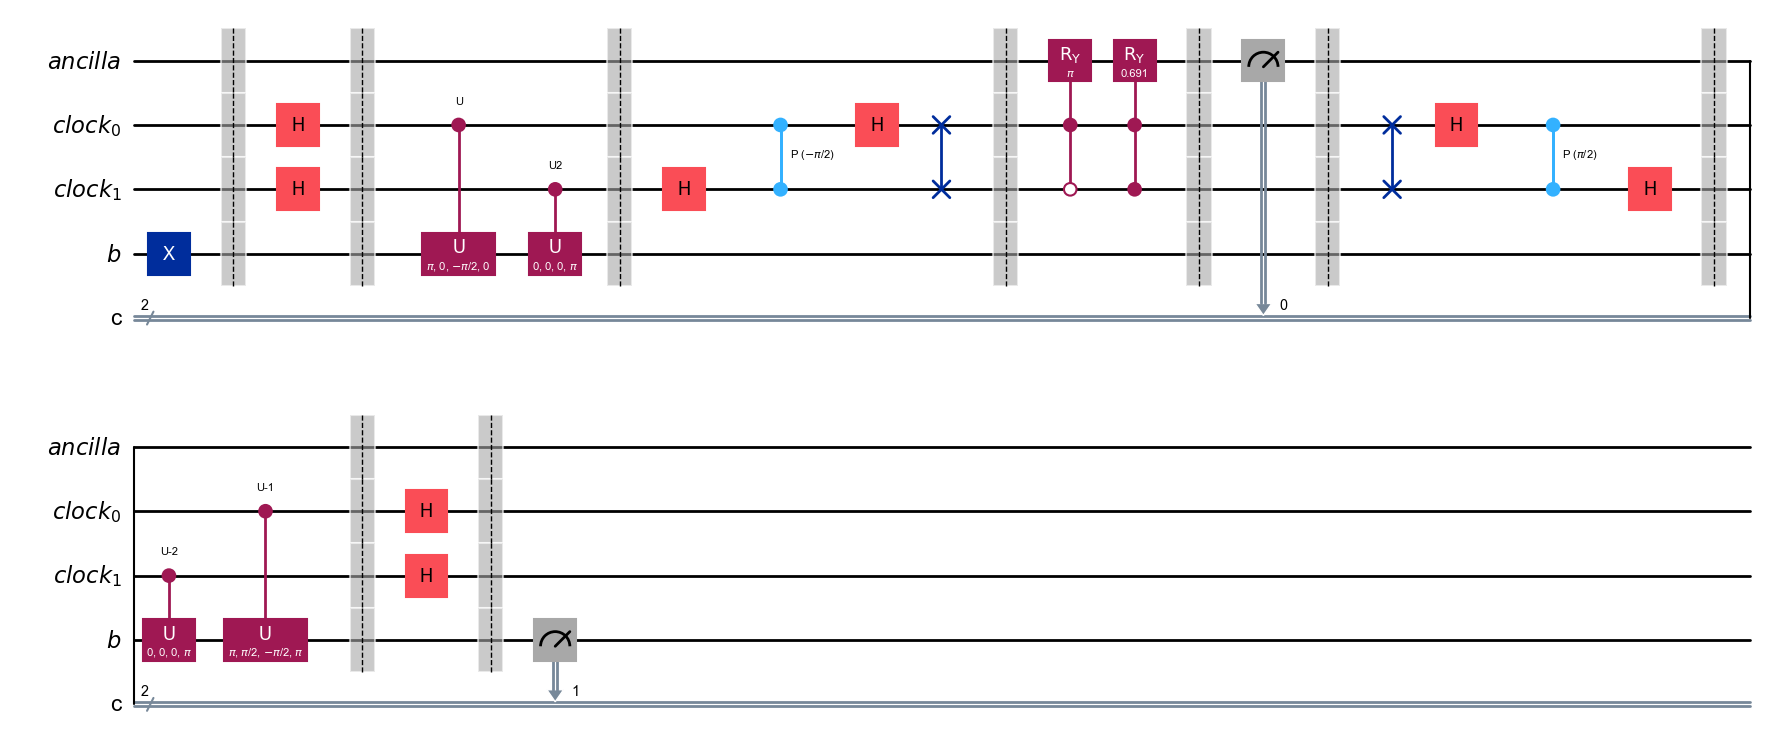

In [20]:
# --- Circuit Construction ---

# Create registers
clock = QuantumRegister(2, name='clock')
input_reg = QuantumRegister(1, name='b') # 1 qubit for 2x2 matrix
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create circuit
circuit = QuantumCircuit(ancilla, clock, input_reg, measurement)

# 1. State Preparation: b = [0, 1] which corresponds to state |1>
# Initialize input_reg to |1>
circuit.x(input_reg)

circuit.barrier()

# 2. Hadamard on Clock
circuit.h(clock)

# 3. Run HHL
hhl(circuit, ancilla, clock, input_reg, measurement)

# 4. Hadamard on Clock (Post-processing part of HHL often mirrors setup)
circuit.h(clock)

circuit.barrier()

# 5. Measure the output (solution x)
# We measure the input register into the second classical bit
circuit.measure(input_reg, measurement[1])

# Draw the circuit
circuit.draw('mpl', scale=1)

Task 3: Analysis of Results

Raw Counts: {'10': 2242, '11': 4440, '00': 2189, '01': 1129}
Counts where Ancilla = 1 (Successful Rotation): {'11': 4440, '01': 1129}

--- Analysis ---
Measured |0> (Classical x0): 1129
Measured |1> (Classical x1): 4440
Measured Ratio (Count 1 / Count 0): 3.9327
Expected Ratio (from Task 2): 2.0 (Amplitudes) -> 4.0 (Probabilities)
Did we get close? 3.932683790965456 approx 4.0?


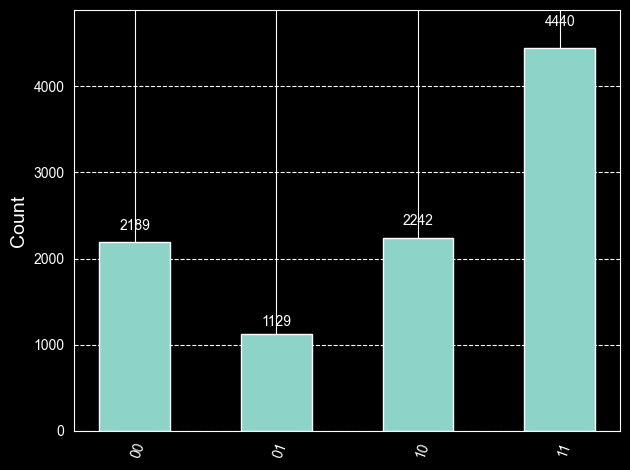

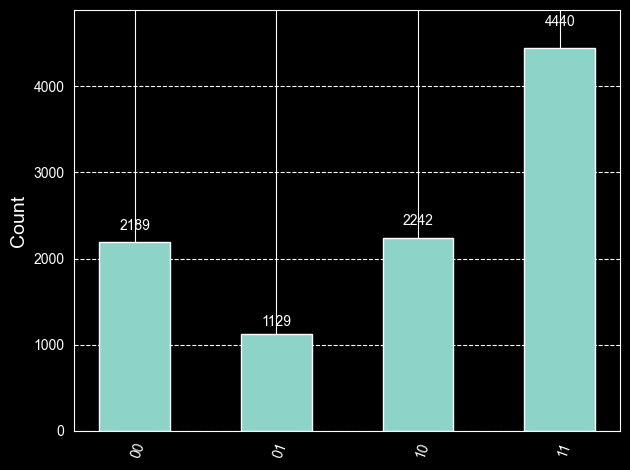

In [21]:
# --- Task 3: Execution and Analysis ---

# Execute
simulator = AerSimulator()
transpiled_circuit = transpile(circuit, simulator)
shots = 10000
job = simulator.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()

# Filter counts where ancilla (lower bit c[0]) is 1
# Keys in counts are 'c[1]c[0]' (High bit is measurement of b, Low bit is ancilla)
success_counts = {k: v for k, v in counts.items() if k.endswith('1')}

print("Raw Counts:", counts)
print("Counts where Ancilla = 1 (Successful Rotation):", success_counts)

# Analyze Solution Ratio
# We look at state |0>_b vs |1>_b given Ancilla is |1>
# Corresponds to keys '01' and '11' in the counts dictionary
count_0 = success_counts.get('01', 0) # Solution state 0
count_1 = success_counts.get('11', 0) # Solution state 1

print(f"\n--- Analysis ---")
print(f"Measured |0> (Classical x0): {count_0}")
print(f"Measured |1> (Classical x1): {count_1}")

if count_0 > 0:
    measured_ratio = count_1 / count_0
    prob_ratio = count_0 / (count_0 + count_1)

    print(f"Measured Ratio (Count 1 / Count 0): {measured_ratio:.4f}")

    # Compare with Classical Expectations
    # Classical x = [1/3, 2/3]. Ratio x1/x0 = 2.
    # Probability ratio P(1)/P(0) = (2/3)^2 / (1/3)^2 = 4.
    print(f"Expected Ratio (from Task 2): 2.0 (Amplitudes) -> 4.0 (Probabilities)")

    print(f"Did we get close? {measured_ratio} approx 4.0?")
else:
    print("Insufficient counts for ratio analysis.")

plot_histogram(counts)